In [2]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange
from stardate.lhf import gk_rotation_model
import stardate
from itertools import product

mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs,vz='v_b'):
    min_star=15
    max_star=30
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
            
            
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        binfs_new=binfs
        while sum(mask)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            
            
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.std(iso_age_err_single)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['iso_age_ave']=iso_ave
    df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs,min_star=5,max_star=30,vz='v_b'):
    countsNo=0
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """        
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(df))
        

    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        
        binfs_new=binfs
        switch=0
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
            binfs_new=[i*1.1 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        while len(vels_single)>max_star:
            if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
            binfs_new=[i*0.9 for i in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            mask=np.ones(dflen, dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[i,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            switch=1
            
        if switch==1:
            countsNo=countsNo+1
        
                
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
                
                
    p_mp, p_mr, p_a = get_avr_coefficients()
    df['vel_dis']=kin_age
    df['kin_age']=v_to_age(kin_age,p_mr)
    print(countsNo)
    return kin_age,v_to_age(kin_age,p_mr)

    

# get average ages
def getkinAges_err(df,fs,fs_err,binfs,min_star=5,max_star=30,sampsize=50,vz='v_b',vz_err='v_b_err'):
    # generate new data
    newDatas=np.zeros((len(df),len(fs),sampsize))
    
    ages=np.zeros((len(df),sampsize))
    
    for i in range(len(fs)):
        if 'Prot' in fs[i]:
            newDatas[:,i,:]=np.log10(getErr(df[fs[i]],df[fs_err[i]],sampsize))
        else:
            newDatas[:,i,:]=getErr(df[fs[i]],df[fs_err[i]],sampsize)
    
    # generate new vb data
    newVbs=np.zeros((len(df),sampsize))
    newVbs=getErr(df[vz],df[vz+'_err'],sampsize)
    
    newfs=[i+'_new' for i in fs]
    for i in range(sampsize):
        print(i/sampsize)
        for j in range(len(fs)):
            df[newfs[j]]=newDatas[:,j,i]
        df[vz+'_new']=newVbs[:,i]
        _,ages[:,i]=getkinAges(df,newfs,binfs,vz=vz+'_new',min_star=min_star)
    return ages




def getVs(px,pmra,pmdec,ra,dec):
    """ Calculates tangential velocity (v_tan) and vertical velocity proximation (v_b).
    
    Args:
      df ([Pandas DataFrame]): DataFrame contains columns 'parallax', 'pmra', 'pmdec', 'ra', 'dec', which are parallax, ra proper motion, dec propermotion, right ascension and declination, respectively  
    
    Returns:
      :v_t ([array-like]): Tangential velocity
      :v_b ([array-like]): Proxy for vertical velocity
    """
    d = coord.Distance(parallax=np.array(px) * u.mas,allow_negative=True)
    vra = (np.array(pmra)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    vdec = (np.array(pmdec)*u.mas/u.yr * d).to(u.km/u.s, u.dimensionless_angles())
    v_t=np.sqrt(np.power(vra,2.)+np.power(vdec,2.)) # vtan
    # v_b as a proxy for v_z:
    c = coord.SkyCoord(ra=np.array(ra)*u.deg, dec=np.array(dec)*u.deg, distance=d,
                  pm_ra_cosdec=np.array(pmra)*u.mas/u.yr,
                  pm_dec=np.array(pmdec)*u.mas/u.yr)
    gal = c.galactic
    v_b = (gal.pm_b * gal.distance).to(u.km/u.s, u.dimensionless_angles()) # vb
    return v_t,v_b

def getErr(x,x_errs,numb):
    newX=np.zeros((len(x),numb))
    for i in range(len(x)):
        newX[i,:]=np.random.normal(x[i], x_errs[i], numb)
    return newX

def getDust(G, bp, rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)


def bv_to_teff(BV):
    BV=np.array(BV)
    #return np.power(BV+0.4,-2./3.)*5601.
    return 5000.*(np.power(0.92*BV+1.7,-1.)+np.power(0.92*BV+0.62,-1.))

def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

def optimizeBins(df,df_match,fs,binmin,binmax,min_star=5,max_star=30,df_match_name='age',df_match_name_err='age_err',vz='v_b',bintestNo=10,errVals=False):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    if errVals:
        df_common=pd.merge(df[np.append(['KID','kin_age_err'],fs)],df_match[['KID',df_match_name,df_match_name_err]],left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err,'kin_age_err']]
        df_common.dropna(subset=['kin_age_err'])
    else:                                                                             
        df_common=pd.merge(df[np.append(['KID'],fs)],df_match,left_on='KID',right_on='KID',how='inner')[['KID',df_match_name,df_match_name_err]]
    
    commonKID=df_common['KID'].values
    
    fslen=len(fs)
    dflen=len(commonKID)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((len(df),fslen))
    
    """
    # subtract MS
    z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
       -3.54673368e-01,3.51882114e+02]
    p = np.poly1d(z)
    for i in range(len(fs)):
        if 'abs_G' in fs[i]:
            df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
            fs[i]='abs_G_sub'
    """    
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    KIDs=df['KID'].values
    
    vels=df[vz].values
    kin_age=np.zeros(len(commonKID))
    No_stars=np.zeros(len(commonKID))
    
    binfs=np.zeros((fslen,bintestNo))
    
    for k in range(fslen):
        binfs[k,:]=np.linspace(binmin[k],binmax[k],bintestNo)
    
    
    testbins=[]
    
    sums=''
    a=['i'+str(i)+',' for i in range(fslen)]
    for i in a:
        sums=sums+i
    
    for a in product(range(bintestNo), repeat=len(a)):
        evalint=[binfs[j,a[j]] for j in range(len(a))]
        #print(evalint)
        testbins.append(evalint)

    
    # optimization
    count=0
    
    for k in trange(len(testbins)):
        binfs=testbins[k]
        for i in range(len(commonKID)):
            ind=np.where(KIDs==commonKID[i])

            mask=np.ones(len(df), dtype=bool)
        
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
            vels_single=vels[mask]
            
            binfs_new=binfs
        
            
            while len(vels_single)<min_star:
                if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*1.1 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
                
            while len(vels_single)>max_star:
                if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
                    break
                #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
                binfs_new=[ii*0.9 for ii in binfs_new]
                mask=np.ones(len(df), dtype=bool)
                for j in range(fslen):
                    checkpara[j]=paras[ind,j]
                    mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
                vels_single=vels[mask]
            
            kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
            No_stars[i]=len(vels_single)
        
        df_common['veldisp']=kin_age
        df_common['kin_age']=v_to_age(df_common['veldisp'],p_mr)
        
        kinages = df_common['kin_age'].values
        m = (kinages!=kinages)
        kinages[m] = -999
        df_common['kin_age'] = kinages
        df_test = df_common
        
        
        if count==0:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:
                chisq=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            df_best=df_test
            opt_binsize=binfs
            count=count+1
        else:
            if errVals:
                sigma=df_test[df_match_name_err]**2+df_test['kin_age_err']**2
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./sigma))/len(df_test)
            else:        
                chisq_new=sum(((df_test[df_match_name]-df_test['kin_age'])**2./np.power(df_test[df_match_name_err],2.)))/len(df_test)
            if chisq_new<chisq:
                opt_binsize=binfs
                chisq=chisq_new
                df_best=df_test
            count=count+1
        
    
    checkpara=np.zeros(fslen)
    
    for i in trange(len(commonKID)):
        ind=np.where(KIDs==commonKID[i])

        mask=np.ones(len(df), dtype=bool)
        """
        # subtract MS
        z=[ 7.43269812e-21,-2.85871860e-16 ,4.37669326e-12,-3.47574268e-08,1.52548746e-04,
           -3.54673368e-01,3.51882114e+02]
        p = np.poly1d(z)
        
        for i in range(len(fs)):
            if 'abs_G' in fs[i]:
                df['abs_G_sub']=df['abs_G']-p(df['teff_calc'])
                fs[i]='abs_G_sub'
        """    
        for j in range(fslen):
            checkpara[j]=paras[ind,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<opt_binsize[j]/2)

        vels_single=vels[mask]
        binfs_new=opt_binsize
            
            
        while len(vels_single)<min_star:
            if any([binfs_new[jj]>2*opt_binsize[jj] for jj in range(len(opt_binsize))]):
                break
            binfs_new=[ii*1.1 for ii in binfs_new]
            mask=np.ones(len(df), dtype=bool)
            for j in range(fslen):
                checkpara[j]=paras[ind,j]
                mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
            vels_single=vels[mask]
            #print(len(vels_single),binfs_new)
            
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        No_stars[i]=len(vels_single)
            
    df_common['kin_age']=v_to_age(kin_age,p_mr)
    kinages = df_common['kin_age'].values
    m = (kinages!=kinages)
    kinages[m] = -999
    df_common['kin_age'] = kinages
        
    df_common['NumbStars']=No_stars
    df_common['measure_age']=df_common[df_match_name]
    df_common['measure_age_err']=df_common[df_match_name_err]

    if errVals:
        df_common['kin_age_err']=df_common['kin_age_err']
        return opt_binsize, df_common[['KID','kin_age','kin_age_err','measure_age','measure_age_err','NumbStars']],chisq
    else:
        return opt_binsize, df_common[['KID','kin_age','measure_age','measure_age_err','NumbStars']],chisq

    

        

def GetParaErrors(df,samp=1000):
    vts=np.zeros((len(df),samp))
    vbs=np.zeros((len(df),samp))
    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    pmra_s=getErr(df['pmra'].values,df['pmra_error'].values,samp)
    pmdec_s=getErr(df['pmdec'].values,df['pmdec_error'].values,samp)
    ra_s=getErr(df['ra'].values,df['ra_error'].values,samp)
    dec_s=getErr(df['dec'].values,df['dec_error'].values,samp)
    for i in trange(samp):
        vts[:,i],vbs[:,i]=getVs(px_s[:,i],pmra_s[:,i],pmdec_s[:,i],ra_s[:,i],dec_s[:,i])
    
    vt_err=np.zeros(len(df))
    vb_err=np.zeros(len(df))

    for i in trange(len(df)):
        vt_err[i]=np.std(vts[i,:])
        vb_err[i]=np.std(vbs[i,:])  
    
    df['v_t_err']=vt_err
    df['v_b_err']=vb_err

    absg_err=np.zeros((len(df),samp))

    px_s=getErr(df['parallax'].values,df['parallax_error'].values,samp)
    
    for i in trange(samp):
        absg_err[:,i]=m_to_M(df.phot_g_mean_mag.values, 1./px_s[:,i])


    absg_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        absg_err_err[i]=np.std(absg_err[i,:])
    df['abs_G_err']=absg_err_err

    Ro_err=np.zeros((len(df),samp))
    mass_s=getErr(df['mass'].values,df['mass_err1'].values,samp)
    Prot_s=getErr(df['Prot'].values,df['Prot_err'].values,samp)
    
    for i in trange(samp):
        Ro_err[:,i]=Prot_s[:,0]/stardate.convective_overturn_time(mass_s[:,i])

    Ro_err_err=np.zeros(len(df))
    for i in trange(len(df)):
        Ro_err_err[i]=np.std(Ro_err[i,:])
    df['Ro_err']=Ro_err_err
    
    return df


def findstars(df,f1_star,f2_star,f3_star,f1='color_teffs',f2='Prot',f3='abs_G'):
    KIDs=np.zeros(len(f1_star))
    count=0
    for i in range(len(f1_star)):
        update_progress(i/len(f1_star))
        teff,prot,abs_g=f1_star[i],f2_star[i],f3_star[i]
        df['dist']=np.power(df[f1]-teff,2.)+np.power(df[f2]-prot,2.)+np.power(df[f3]-prot,2.)
        KIDs[count]=df.sort_values(by=['dist'])['KID'].iloc[0]
        count=count+1
    return KIDs


def countstars(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    starNo=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        starNo[i]=sum(mask)
    return starNo
        
    
def calcChi2(x,y,xerr,yerr):
    return sum(np.power(x-y,2)/(xerr**2.+yerr**2.)/len(x))

def calc_tc(teff):
    return 314.24*np.exp(-(teff/1952.5)-(teff/6250)**18)+0.002

# Kepler data

In [3]:
# santos Kepler catalog
from astropy.io import ascii
kepler = ascii.read('santos2021.txt').to_pandas()
gaiakepler = readfits('../AgeBinary/kepler_dr3_1arcsec.fits')

In [4]:
kepler = pd.merge(kepler, gaiakepler, left_on='KIC',
                 right_on='kepid',how='inner')

In [5]:
rv = ascii.read('Angus2022.txt').to_pandas()
kepler = pd.merge(kepler, rv, left_on='KIC', right_on='KIC',
                 how='left')


In [6]:
kepler = kepler.drop_duplicates('KIC').reset_index(drop=True)
len(kepler)
#gaiakinmat = pd.read_pickle('dr3_kinematic.pkl')
gaiakinmat['source_id_int'] = np.array([i.split(' ')[-1] for i in gaiakinmat['source_id']],
                                       dtype=int)
kepler = pd.merge(kepler, gaiakinmat[['source_id_int','x','y','z','vx','vy','vz','feh']],
                 left_on='source_id',right_on='source_id_int',how='left')
len(kepler)



NameError: name 'gaiakinmat' is not defined

In [ ]:
#kepler.to_pickle('SantosKepler.pkl')

In [42]:

rvcomb = np.zeros(len(kepler))*np.nan
rvgaia = kepler['vz'].values
rvinf = kepler['vz-inferred'].values
rvspec = kepler['vz-calc'].values

for i in trange(len(kepler)):
    if rvgaia[i]==rvgaia[i]:
        rvcomb[i]=rvgaia[i]
    elif rvinf[i]==rvinf[i]:
        rvcomb[i]=rvinf[i]
    elif rvspec[i]==rvspec[i]:
        rvcomb[i]=rvspec[i]
        
kepler['allvz'] = rvcomb

100%|██████████| 39497/39497 [00:00<00:00, 803940.66it/s]


# dered

In [70]:
from dustmaps.bayestar import BayestarQuery
bayestar = BayestarQuery(max_samples=2, version='bayestar2019')
print("Calculating Ebv")

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 18.943 s
  pix_info:   0.410 s
   samples:   8.322 s
      best:   4.090 s
       nan:   0.045 s
      sort:   5.943 s
       idx:   0.132 s
Calculating Ebv


In [71]:
def getDust(G, bp_rp, ebv, maxnit=100):
    """
    Compute the Gaia extinctions assuming relations from Babusieux.
    Author: Sergey Koposov skoposov@cmu.edu
    Args:
        G (float): Gaia G mag.
        bp (float): Gaia BP mag.
        rp (float): Gaia RP mag.
        ebv (float): E(B-V), extinction in B-V.
        maxnit (int): number of iterations
    Returns:
        Extinction in G,bp, rp
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp_rp+G)
    curbp = bp_rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp_rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        curbp = curbp1

    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp

In [128]:
kepler = kepler.loc[kepler['parallax']>0]

In [129]:
import astropy.units as units
coords = SkyCoord(kepler.ra.values*units.deg, kepler.dec.values*units.deg,
                  distance=1/(kepler.parallax.values)*units.kpc)
ebv, flags = bayestar(coords, mode='percentile', pct=[16., 50., 84.],
                      return_flags=True)
# Calculate Av
Av_bayestar = 2.742 * ebv
print(np.shape(Av_bayestar), "shape")
Av = Av_bayestar[:, 1]
Av_errm = Av - Av_bayestar[:, 0]
Av_errp = Av_bayestar[:, 2] - Av
Av_std = .5*(Av_errm + Av_errp)

kepler["ebv"] = ebv[:, 1]  # The median ebv value.
kepler["Av"] = Av
kepler["Av_errp"] = Av_errp
kepler["Av_errm"] = Av_errm
kepler["Av_std"] = Av_std

(38876, 3) shape


In [130]:
kepler['gmag'] = m_to_M(kepler['phot_g_mean_mag'], 1/kepler['parallax'])

In [131]:
# Calculate dereddened photometry
AG, Abp, Arp = getDust(kepler.gmag.values,
                       kepler.bp_rp.values, 
                       kepler.ebv.values)

In [141]:
kepler["bprp_dered"] = kepler.bp_rp.values-Abp+Arp
kepler["abs_G"] = kepler.gmag.values - AG

In [182]:
import numpy as np


def bprp_to_teff(bprp):
    """
    Calculate photometric Teff from Gaia color (use dereddened color!)
    Args:
        bprp (array): Gaia G_BP colour minus Gaia G_RP colour.
    Returns:
        teffs (array): Photometric effective temperatures.
    """

    coeffs = [8959.8112335205078, -4801.5566310882568, 1931.4756631851196,
            -2445.9980716705322, 2669.0248055458069, -1324.0671020746231,
            301.13205924630165, -25.923997443169355]
    """
    # Jason's updated parameters:
    coeffs = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5,
              -2694.76, 192.865]
    """

    return np.polyval(coeffs[::-1], bprp)




In [183]:
kepler['teff_calc'] = bprp_to_teff(kepler['bprp_dered'])

In [184]:
kepler.to_pickle('SantosKepler.pkl')

In [186]:
#plt.plot(kepler['teff_calc'],kepler['Prot'],'k.', alpha=0.2)
#len(kepler['teff_calc']), len(kepler['teff_calc'].dropna())

# ZTF dr3 RVs

In [2]:
kepler = pd.read_pickle('SantosKepler.pkl')

In [173]:
ztf = pd.read_pickle('./new_age_ztf.pkl')
ztf = ztf.loc[~ztf['KIC_x'].isin(kepler['kepid'])].reset_index(drop=True)
len(ztf)

12308

In [4]:
ztf['source_id'] = ztf['gaiaid']

In [5]:
ztf['allvz'] = ztf['vz']

In [6]:
both = pd.concat([kepler[['source_id','allvz','teff_calc','Prot','abs_G','KIC']], 
                  ztf[['source_id','allvz','teff_calc','Prot','abs_G']]])


In [7]:
both = both.dropna(subset=['Prot','allvz','abs_G','teff_calc']).reset_index(drop=True)
len(both)

47920

# get ages

In [150]:
df = both


In [151]:
df['τc'] = calc_tc(df['teff_calc'])
df['Ro'] = df['Prot']/df['τc']

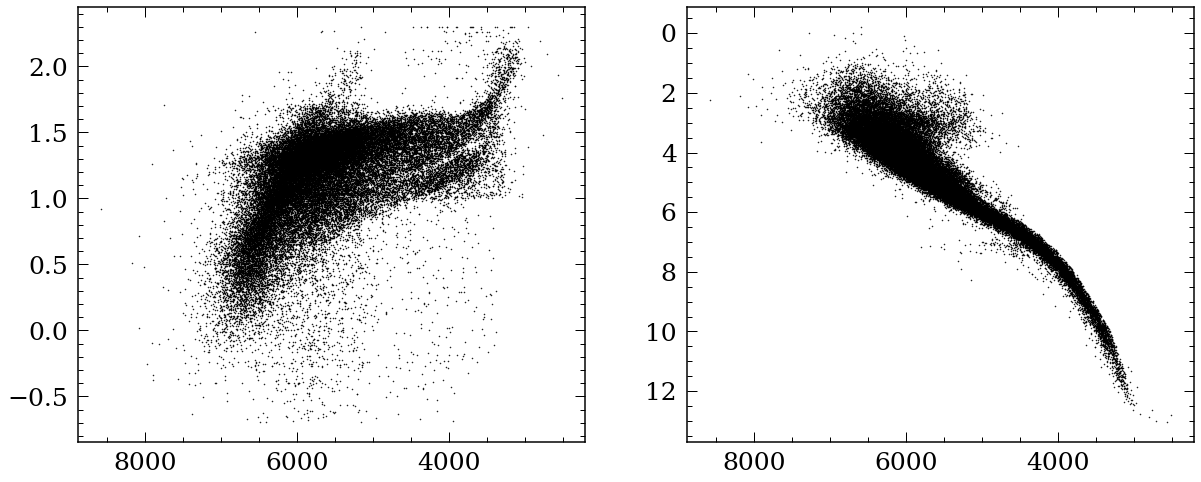

In [152]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df['teff_calc'], np.log10(df['Prot']), 'k.', markersize=1)
plt.gca().invert_xaxis()
plt.subplot(1,2,2)
plt.plot(df['teff_calc'], df['abs_G'], 'k.', markersize=1)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

46849


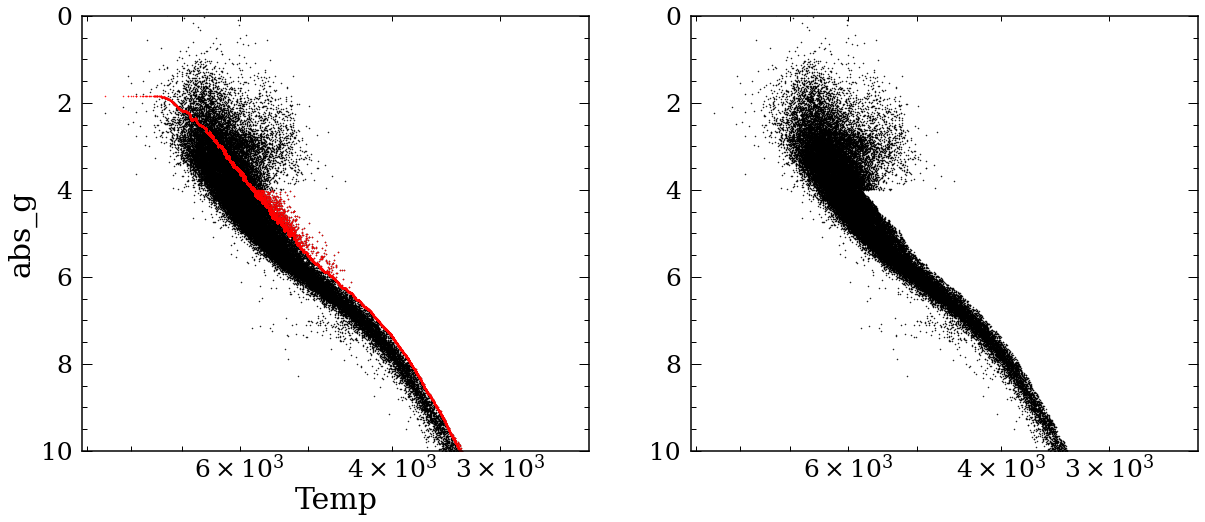

In [153]:
plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.semilogx(df['teff_calc'],df['abs_G'],'k.',markersize=1)
df = df.sort_values(by='teff_calc').reset_index(drop=True)
absgsmooth = gaussian_filter(df['abs_G'].values, 100)

plt.semilogx(df['teff_calc'],absgsmooth-0.4,'r.',markersize=1)

m=df['abs_G']<absgsmooth-0.4
m=m&(df['abs_G']>4)

plt.semilogx(df['teff_calc'][m],df['abs_G'][m],'r.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel('Temp')
plt.ylabel('abs_g')

plt.subplot(1,2,2)
df_nob = df[~m].reset_index(drop=True)
plt.semilogx(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

print(len(df_nob))

In [154]:
ASstars = pd.read_csv('ASage.csv')  

ASKICs = ASstars['KIC'].unique()
ASage = np.zeros(len(ASKICs))
ASage_err = np.zeros(len(ASKICs))
for i in range(len(ASKICs)):
    singstar = ASstars.loc[ASstars['KIC']==ASKICs[i]]
    ASage_err[i] = max(singstar['Age'])-min(singstar['Age'])
    ASage[i] = np.mean(singstar['Age'])
ASages = pd.DataFrame(np.array((ASKICs, ASage, ASage_err)).T, columns=['KIC','Age','Age_err'])
ASages = pd.merge(ASages, df_nob, left_on='KIC', right_on='KIC', how='inner')
ASages = ASages.loc[ASages['Ro']<2].reset_index(drop=True)
len(ASages), ASages.columns


(25,
 Index(['KIC', 'Age', 'Age_err', 'source_id', 'allvz', 'teff_calc', 'Prot',
        'abs_G', 'τc', 'Ro'],
       dtype='object'))

In [155]:
from astropy.io import ascii
clusters = (ascii.read('ocage')).to_pandas()
len(clusters), clusters.columns


(923,
 Index(['Cluster', 'Age', 'Avmag', 'DR2Name', 'Oname', 'RAdeg', 'DEdeg',
        'BP-RP', '(BP-RP)0', 'Gmag', 'MGmag', 'Teff', 'Prot'],
       dtype='object'))

In [156]:
clusterkids = range(len(clusters))
clusterteffs = clusters['Teff'].values
clusterprotlog = np.log10(clusters['Prot'].values)
clusterabsg = clusters['MGmag'].values
clusterro = clusters['Prot'].values/calc_tc(clusterteffs)
clusterprot = clusters['Prot'].values
clustervz = np.zeros(len(clusters))
clusterage = clusters['Age'].values
clusterage_err = clusters['Age'].values*0.05
clusterdf = pd.DataFrame(np.array((clusterkids,clusterteffs,clusterprotlog,clusterabsg,clusterro,clustervz,clusterage,clusterage_err,clusterprot)).T,
                        columns=['KID','teff_calc','Prot_log','abs_G','Ro','vz','Age','Age_err','Prot'])

clusterdf = clusterdf.loc[clusterdf['Ro']<2].reset_index(drop=True)
clusterdf = clusterdf.loc[clusterdf['teff_calc']<5000].reset_index(drop=True)
clusterdf = clusterdf.loc[clusterdf['Age']>1].reset_index(drop=True)
clusterAS = pd.concat([ASages, clusterdf])
print(len(clusterAS))


52


In [157]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

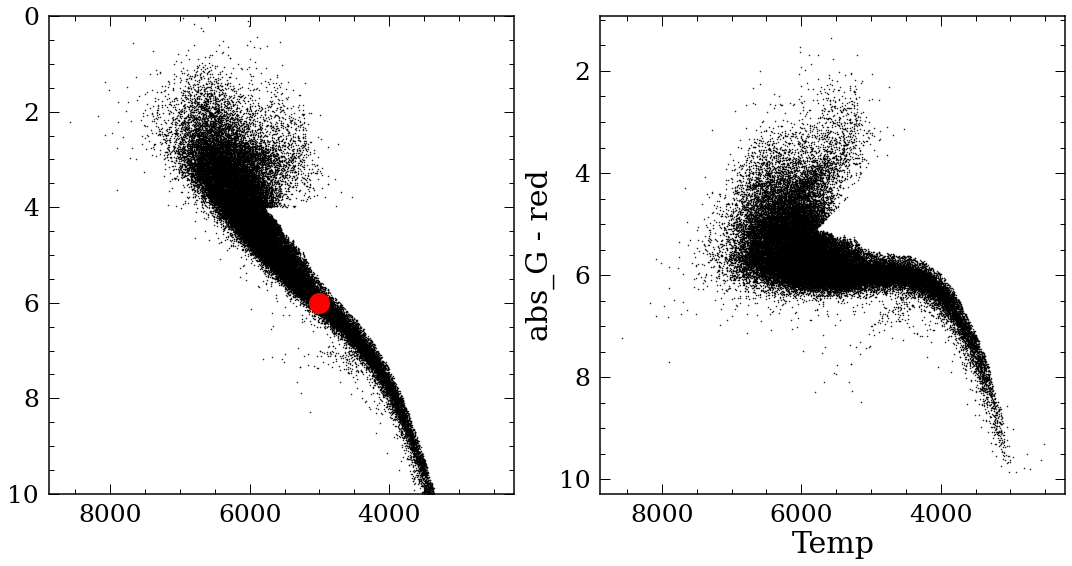

In [158]:
from scipy.ndimage import gaussian_filter
from scipy.spatial.transform import Rotation as R

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'],df_nob['abs_G'],'k.',markersize=1)
#plt.plot(clusterAS['teff_calc'], clusterAS['abs_G'],'ro')

plt.plot([5e3],[6],'ro',markersize=20)

df_nob = df_nob.sort_values(by='teff_calc').reset_index(drop=True)

"""
r = R.from_euler('xyz',(80,80,0), degrees=True) 
p_r=r.apply(np.array([df_nob['teff_calc'].values,df_nob['abs_G'].values,
                      np.zeros(len(df_nob))]).T) #Rotated points
"""

df_nob['teff_rot'],df_nob['abs_G_rot'] = rotate([5e3,6],[df_nob['teff_calc'].values,df_nob['abs_G'].values],0.0014)

plt.ylim([0,10])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.plot(x,y,'k.',markersize=1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()


plt.xlabel('Temp')
plt.ylabel('abs_G - red')
plt.tight_layout()

In [159]:
df_nob['KID'] = df_nob['KIC']

In [160]:
clusterAS = pd.merge(clusterAS[['KID','Age','Age_err']].dropna(), df_nob, left_on='KID',
                    right_on='KID',how='inner')



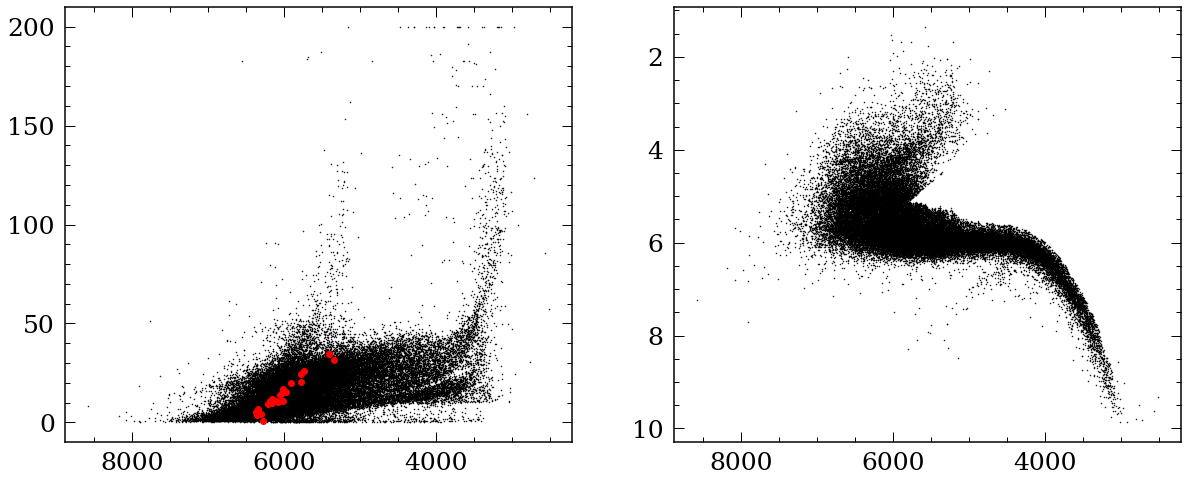

In [161]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(df_nob['teff_calc'], df_nob['Prot'], 'k.', markersize=1)
plt.plot(ASages['teff_calc'], ASages['Prot'], 'ro')
plt.gca().invert_xaxis()

plt.subplot(1,2,2)
plt.plot(df_nob['teff_calc'], df_nob['abs_G_rot'], 'k.', markersize=1)
plt.plot(clusterAS['teff_calc'], clusterAS['abs_G_rot'], 'ro')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()



In [162]:
df_nob['Prot_log'] = np.log10(df_nob['Prot'])

In [163]:
#df_nob = df_nob.drop_duplicates('source_id')
df_nob = df_nob.reset_index(drop=True)
ASages = ASages.reset_index(drop=True)

In [164]:
ASages['KID'] = ASages['KIC']

In [165]:
print(len(df_nob))
df_nob = df_nob.dropna(subset=['teff_calc','abs_G_rot','Ro','Prot_log','allvz']).reset_index(drop=True)
print(len(df_nob))

opt_binsize, df_common, chisq = optimizeBins(df_nob, ASages, ['teff_calc','abs_G_rot','Ro','Prot_log'],
                                             [50,0.01,0.01,0.1],[500,0.3,0.3,1],
                                             min_star=15,max_star=50000,df_match_name='Age',
                                             df_match_name_err='Age_err',vz='allvz',
                                             bintestNo=10,errVals=False)

df_common = pd.merge(df_common, df_nob[['KID','Ro']], 
                     left_on='KID', right_on='KID', how='inner')
opt_binsize, chisq

46849
46849


  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
/opt/homebrew/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
100%|██████████| 25/25 [00:00<00:00, 526.73it/s]


([200.0, 0.01, 0.1711111111111111, 0.30000000000000004], 2.7340287485554176)

Text(0, 0.5, 'Gyro-kinematic Age [Gyr]')

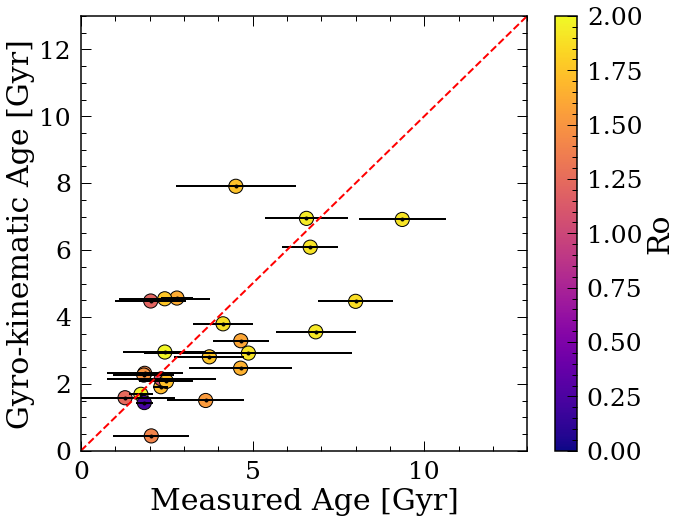

In [175]:


plt.figure(figsize=(10,8))
plt.errorbar(df_common['measure_age'],df_common['kin_age'],
             xerr=df_common['measure_age_err'],
             fmt='k.')

plt.scatter(df_common['measure_age'],df_common['kin_age'],
             c=df_common['Ro'],s=200,edgecolor='k',vmin=0,vmax=2,
           cmap='plasma')
cb = plt.colorbar()
cb.set_label('Ro')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')




In [176]:
df_nob['vel_dis'],df_nob['kin_age']=getkinAges(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                                              opt_binsize,vz='allvz',min_star=15,
                                               max_star=50000)




100%|██████████| 46849/46849 [01:09<00:00, 677.75it/s]

46489



<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Text(0, 0.5, 'M$_G$')

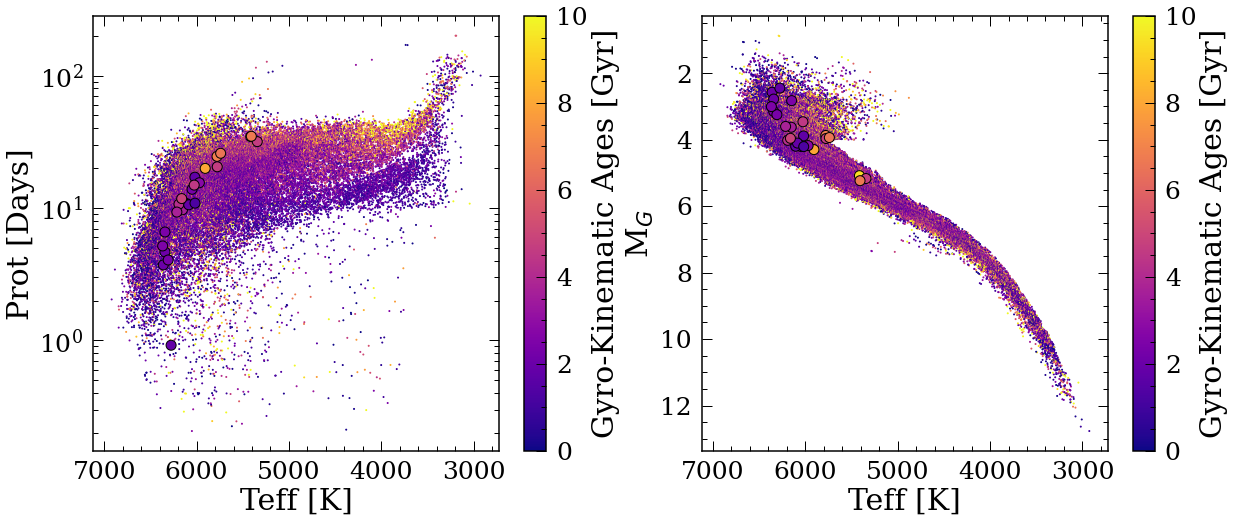

In [194]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=1,
            vmin=0,vmax=10,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['Prot'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(1,2,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G'], c=df_nob['kin_age'],s=1,
           vmin=0,vmax=10,cmap='plasma')
plt.scatter(ASages['teff_calc'], ASages['abs_G'], c=ASages['Age'],s=100,edgecolor='k',
           vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')




(10, 150)

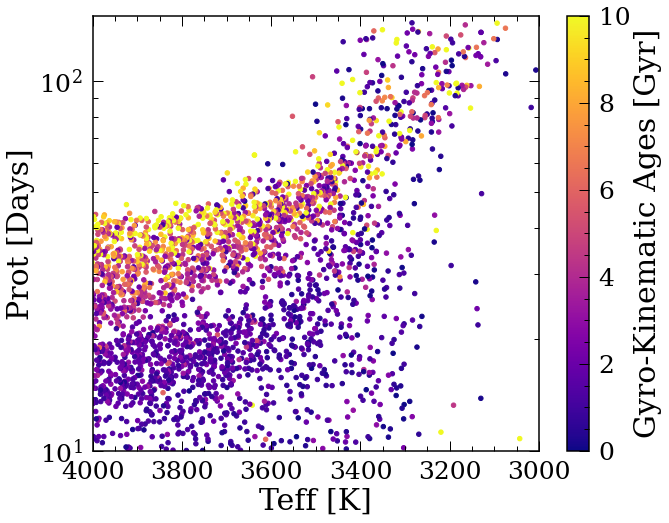

In [179]:
plt.figure(figsize=(10,8))
"""plt.hexbin(df_nob['teff_calc'], df_nob['Prot'], C=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',extent=(3000,4500,np.log10(10),np.log10(150)),
           yscale='log',gridsize=50)"""

plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],
            vmin=0,vmax=10,cmap='plasma',s=20)
plt.scatter(ASages['teff_calc'], ASages['Prot'], c=ASages['Age'],s=100,
            edgecolor='k',vmin=0,vmax=10,cmap='plasma')
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')
plt.yscale('log')
plt.xlim([4000,3000])
plt.ylim([10,150])
#plt.vlines(3450,ymax=150,ymin=10,color='r')
#plt.vlines(3400,ymax=150,ymin=10,color='r')



In [188]:
fullyconvective = df_nob.loc[(df_nob['teff_calc']>3400)&(df_nob['teff_calc']<3450)]
gap = df_nob.loc[(df_nob['teff_calc']>3600)&(df_nob['teff_calc']<3650)]



Text(0, 0.5, 'Period [Days]')

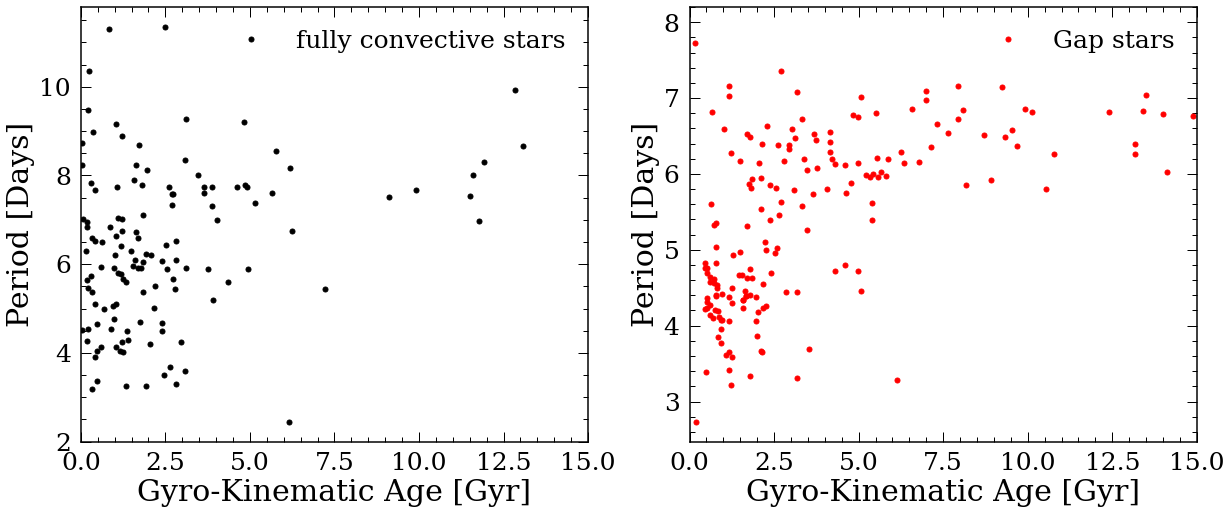

In [193]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(fullyconvective['kin_age'],fullyconvective['Prot']**0.5,'ko',
         label='fully convective stars',markersize=5)
plt.xlim([0,15])
#plt.ylim([0,1.6])
plt.legend()
plt.xlabel('Gyro-Kinematic Age [Gyr]')
plt.ylabel('Period [Days]')

plt.subplot(1,2,2)
plt.plot(gap['kin_age'],gap['Prot']**0.5,'ro',label='Gap stars',markersize=5)
plt.xlim([0,15])
#plt.ylim([0,1.6])
plt.legend()
plt.xlabel('Gyro-Kinematic Age [Gyr]')
plt.ylabel('Period [Days]')

In [180]:
#df_nob.to_pickle('new_age_ztf.pkl')

Text(0, 0.5, 'M$_G$')

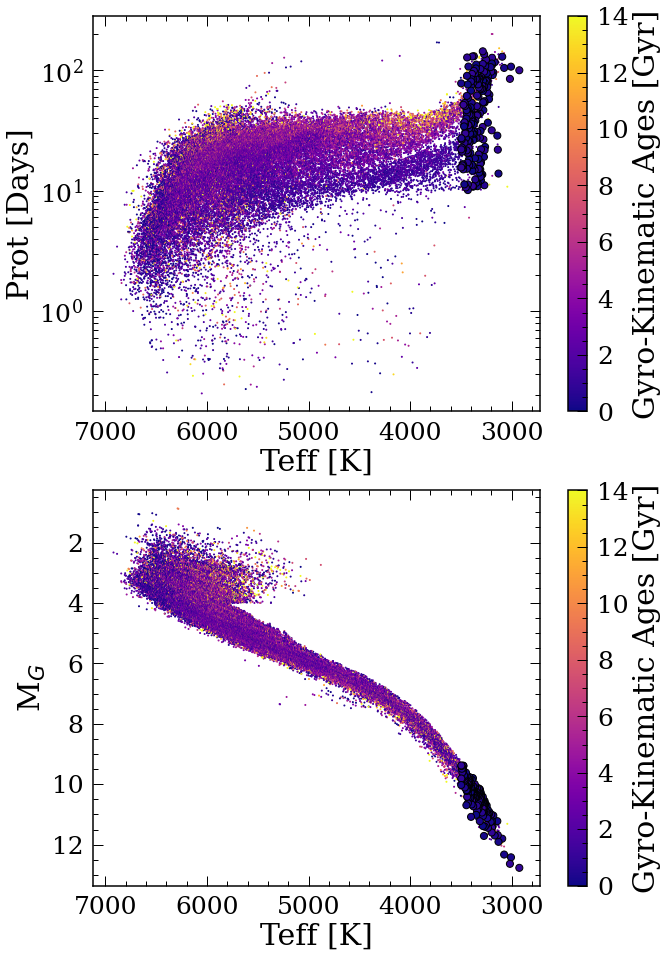

In [183]:
m = df_nob['teff_calc']<3500
m = m&(df_nob['kin_age']<1)

plt.figure(figsize=(10,16))
plt.subplot(2,1,1)
plt.scatter(df_nob['teff_calc'], df_nob['Prot'], c=df_nob['kin_age'],s=1,
            vmin=0,vmax=14,cmap='plasma')
plt.scatter(df_nob['teff_calc'][m], df_nob['Prot'][m], c=df_nob['kin_age'][m],s=50,
            vmin=0,vmax=14,cmap='plasma',edgecolor='k')
plt.gca().invert_xaxis()
plt.yscale('log')
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('Prot [Days]')

plt.subplot(2,1,2)
plt.scatter(df_nob['teff_calc'], df_nob['abs_G'], c=df_nob['kin_age'],s=1,
           vmin=0,vmax=14,cmap='plasma')
plt.scatter(df_nob['teff_calc'][m], df_nob['abs_G'][m], c=df_nob['kin_age'][m],s=50,
            vmin=0,vmax=14,cmap='plasma',edgecolor='k')


plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cb = plt.colorbar()
cb.set_label('Gyro-Kinematic Ages [Gyr]')
plt.xlabel('Teff [K]')
plt.ylabel('M$_G$')





# combine with clusters

In [7]:
df_nob = pd.read_pickle('new_age_ztf.pkl')
M67 = pd.read_csv('m67_analysis_subset.csv')
M67['teff_calc'] = M67['Teff']
M67['Age'] = 4*np.ones(len(M67))
M67['Cluster'] = 'M67'


In [185]:
oc = pd.read_pickle('/Users/yl4331/Desktop/KeplerAges/clusters.pkl')
oc = oc.sort_values(by='AGE').reset_index(drop=True)
oc['teff_calc'] = bprp_to_teff(oc['BP_RP_0'])
oc['Prot'] = oc['PROT']
oc['Age'] = oc['AGE']/1000
oc['Cluster'] = oc['CLUSTER']

oc = pd.concat([oc, M67])

df_bin = df_nob

In [186]:
oc.columns

Index(['CLUSTER', 'DR2NAME', 'DR2_NUM', 'ID', 'ID_SOURCE', 'RA', 'DEC',
       'BP_RP', 'GMAG', 'AGE', 'AV', 'PLX', 'DISTANCE', 'DM', 'BP_RP_0', 'M_G',
       'BINARY_SHORT', 'BINARY_WIDE', 'PROT', 'E_PROT', 'PROT_REF', 'TEFF',
       'MASS', 'BENCH', 'KID', 'AGE_err', 'teff_calc', 'Prot', 'Age',
       'Cluster', 'source_id', 'ps1_id', 'Teff', 'fap'],
      dtype='object')

In [187]:

agebins = np.linspace(0.5,7.5,50)
count = 0

ac = getcolor(agebins,plt.cm.get_cmap('plasma'))
for i in trange(len(agebins)-1):
    minage = agebins[i]
    maxage = agebins[i+1]
    
    if minage<3:
        mincountno = 4
    elif minage<4:
        mincountno = 2
    else:
        mincountno = 1
    
    df_agebin = df_bin.loc[(df_bin['kin_age']>minage)&(df_bin['kin_age']<maxage)]
    
    plt.figure(figsize=(10,8))
    #plt.subplot(1,2,1)
    plt.hexbin(df_bin['teff_calc'],df_bin['Prot'],C=df_bin['kin_age'],
               extent=(3000, 7000,1,np.log10(200)), gridsize=100 ,mincnt=1,
               vmin=0,vmax=10, alpha=0.4,yscale='log',
               cmap=plt.cm.get_cmap('plasma'))
    
    df_agebin = df_agebin.sort_values(by='teff_calc')

    
    teffsmooth, protsmooth = movingMed_time(df_agebin['teff_calc'],
                                            df_agebin['Prot'], 30, 300)
    
    
    if i==1:
        m = oc['Cluster']=='Praesepe'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==4:
        m = oc['Cluster']=='NGC_6811'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==6:
        m = oc['Cluster']=='NGC_752'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==14:
        m = oc['Cluster']=='NGC_6819'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==16:
        m = oc['Cluster']=='Ruprecht_147'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==24:
        m = oc['Cluster']=='M67'
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    else:
        plt.scatter(oc['teff_calc'],oc['Prot'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,edgecolor='k')

    m = (teffsmooth!=0)&(protsmooth!=0)
    plt.plot(teffsmooth[m], protsmooth[m],'-',linewidth=5,color=ac[i])
    

    plt.ylim([1,200])
    plt.xlim([7000, 3000])
    plt.ylabel('Prot [Days]')
    plt.xlabel('$T_{eff}$ [K]')
    #plt.gca().invert_xaxis()
    cb = plt.colorbar()
    cb.set_label('Gyro-kinematic age [Gyr]')
    
    if i==1:
        for j in range(10):
            plt.text(6000,50,'Praesepe\n 0.67 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 4:
        for j in range(10):
            plt.text(6000,50,'NGC 6811\n 1 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 6:
        for j in range(10):
            plt.text(6000,50,'NGC 752\n 1.4 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 14:
        for j in range(10):
            plt.text(6000,50,'NGC 6819\n 2.5 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1        
    elif i==16:
        for j in range(10):
            plt.text(6000,50,'Ruprecht 147\n 2.7 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i==24:
        for j in range(10):
            plt.text(6000,50,'M67\n 4.0 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    else:
        plt.savefig('movie/clips_color_'+str(count)+'.png')
        count = count+1
        
        

    """plt.subplot(1,2,2)
    plt.hexbin(df_bin['teff_calc'],df_bin['abs_G'],C=df_bin['kin_age'],
               extent=(2500,8000,0,15), gridsize=100 ,mincnt=1,
               vmin=0,vmax=10, alpha=0.4,
               cmap=plt.cm.get_cmap('plasma'))
    
    df_agebin = df_agebin.sort_values(by='teff_calc')

    if i==1:
        m = oc['Cluster']=='Praesepe'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['M_G'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==4:
        m = oc['Cluster']=='NGC_6811'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['M_G'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==6:
        m = oc['Cluster']=='NGC_752'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['M_G'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==14:
        m = oc['Cluster']=='NGC_6819'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['M_G'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==16:
        m = oc['Cluster']=='Ruprecht_147'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['M_G'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    elif i==24:
        m = oc['Cluster']=='M67'
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,alpha=0.5)
        plt.scatter(oc[m]['teff_calc'],oc[m]['Prot'],c=oc[m]['Age'],s=100,
                    cmap=plt.cm.get_cmap('plasma'),edgecolor='y',vmin=0,vmax=10)
    else:
        plt.scatter(oc['teff_calc'],oc['M_G'],c=oc['Age'],cmap=plt.cm.get_cmap('plasma'),
                vmin=0,vmax=10,edgecolor='k')
    
    df_agebin = df_agebin.sort_values(by='abs_G')
    protsmooth, teffsmooth = movingMed_time(df_agebin['abs_G'],
                                            df_agebin['teff_calc'],
                                            0.05, 0.3)
    
    m = (teffsmooth!=0)&(protsmooth!=0)
    plt.plot(teffsmooth[m], protsmooth[m],'-',linewidth=5, 
             label="%.2f Gyr < τ < %.2f Gyr"%(minage, maxage),color=ac[i])


    plt.ylim([0,15])
    plt.xlim([2500, 8000])
    plt.ylabel('Gaia Absolute Magnitude [mag]')
    plt.xlabel('$T_{eff}$ [K]')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    cb = plt.colorbar()
    cb.set_label('Gyro-kinematic age [Gyr]')
    plt.legend(loc=3)
    if i==1:
        for j in range(10):
            plt.text(15000,4,'Praesepe\n 0.67 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 4:
        for j in range(10):
            plt.text(15000,4,'NGC 6811\n 1 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 6:
        for j in range(10):
            plt.text(15000,4,'NGC 752\n 1.4 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i == 14:
        for j in range(10):
            plt.text(15000,4,'NGC 6819\n 2.5 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1        
    elif i==16:
        for j in range(10):
            plt.text(15000,4,'Ruprecht 147\n 2.7 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    elif i==24:
        for j in range(10):
            plt.text(15000,4,'M67\n 4.0 Gyr',fontsize=25)
            plt.savefig('movie/clips_color_'+str(count)+'.png')
            count = count+1
    else:
        plt.savefig('movie/clips_color_'+str(count)+'.png')
        count = count+1"""
        
    plt.close()

100%|██████████| 49/49 [00:36<00:00,  1.33it/s]


In [146]:
pwd

'/Users/yl4331/Desktop/NewGyroKineage'

In [194]:
len(df_nob['kin_age'].dropna())

28013

# Use MCMC

In [260]:
def calc_sing_age(df,fs,bins,binfs,matchage,min_star=5,max_star=500000,vz='v_b'):

    df=df.dropna(subset=np.append([vz],fs)).reset_index(drop=True)
    p_mp, p_mr, p_a = get_avr_coefficients()
    
    df=df.reset_index(drop=True)
    
    fslen=len(fs)
    dflen=len(df)
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
            
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df[vz].values

    mask=np.ones(len(df), dtype=bool)

    for j in range(fslen):
        checkpara[j]=bins[j]
        mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2.)
    vels_single=vels[mask]

    binfs_new=binfs


    while len(vels_single)<min_star:
        if any([binfs_new[jj]>2*binfs[jj] for jj in range(len(binfs))]):
            break
        #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
        binfs_new=[ii*1.1 for ii in binfs_new]
        mask=np.ones(len(df), dtype=bool)
        for j in range(fslen):
            checkpara[j]=bins[j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
        vels_single=vels[mask]

    while len(vels_single)>max_star:
        if any([binfs_new[jj]<binfs[jj]/2 for jj in range(len(binfs))]):
            break
        #print([binfs_new[jj]>1.5*binfs[jj] for jj in range(len(binfs))])
        binfs_new=[ii*0.9 for ii in binfs_new]
        mask=np.ones(len(df), dtype=bool)
        for j in range(fslen):
            checkpara[j]=bins[j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs_new[j]/2)
        vels_single=vels[mask]

    kin_age=v_to_age(1.5*np.median(abs(vels_single-np.median(vels_single))),p_mr)
    return kin_age
    



In [261]:
ASages['teff_rot'],ASages['abs_G_rot'] = rotate([5e3,6],[ASages['teff_calc'].values,ASages['abs_G'].values],0.0014)
ASages['Prot_log'] = np.log10(ASages['Prot'])

def log_likelihood(theta):
    chisq=0
    for i in range(len(ASages)):
        kinage = calc_sing_age(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                      ASages.iloc[i][['teff_calc','abs_G_rot','Ro','Prot_log']],
                      theta,
                      ASages.iloc[i]['Age'],
                      vz='allvz')
        if kinage!=kinage:
            kinage=1000
        chisq = chisq+((ASages.iloc[i]['Age']-kinage)/ASages.iloc[i]['Age_err'])**2
    return -0.5 * chisq
    

In [268]:
def log_prior(theta):
    tef, abg, ro, prot = theta
    if 50 < tef < 500 and 0.01 < abg < 1 and 0.01 < ro < 1.0 and 0.01<prot<1:
        return 0.0
    return -np.inf

def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [ ]:
import emcee

pos = [200.0, 0.05, 0.1, 0.1] + 1e-4 * np.random.randn(50, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, 
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 16/5000 [02:23<12:19:07,  8.90s/it]<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
  0%|          | 18/5000 [02:41<12:13:50,  8.84s/it]<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide by zero encountered in log
  logt = np.polyval(coeffs, np.log(v))
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]
<ipython-input-91-3bb63aba61b1>:50: RuntimeWarning: divide 

In [ ]:
fig, axes = plt.subplots(4, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ["Teff", "abs_G", "Ro",'prot']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [ ]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, 
);

In [ ]:
from IPython.display import display, Math
optbin = np.zeros(4)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    optbin[i] = mcmc[1]

In [ ]:
kinages_AS = np.zeros(len(ASages))
realage = np.zeros(len(ASages))
realage_err = np.zeros(len(ASages))
Ros = np.zeros(len(ASages))
for i in range(len(ASages)):
    kinages_AS[i] = calc_sing_age(df_nob,['teff_calc','abs_G_rot','Ro','Prot_log'],
                      ASages.iloc[i][['teff_calc','abs_G_rot','Ro','Prot_log']],
                      optbin,
                      ASages.iloc[i]['Age'],
                      vz='allvz')
    realage[i] = ASages.iloc[i]['Age']
    realage_err[i] = ASages.iloc[i]['Age_err']
    Ros[i] = ASages.iloc[i]['Prot']/calc_tc(ASages.iloc[i]['teff_calc'])


    
plt.figure(figsize=(10,8))
plt.errorbar(realage, kinages_AS,
             xerr=realage_err,
             fmt='k.')

plt.scatter(realage, kinages_AS,
             c=Ros,s=200,edgecolor='k',vmin=0,vmax=2,
           cmap='plasma')
cb = plt.colorbar()
cb.set_label('Ro')
plt.plot([0,13],[0,13],'r--')
plt.xlim([0,13])
plt.ylim([0,13])
plt.xlabel('Measured Age [Gyr]')
plt.ylabel('Gyro-kinematic Age [Gyr]')


print(-2*log_likelihood(optbin)/len(realage))


In [ ]:
df_nob['vel_dis'],df_nob['kin_age']=getkinAges(optbin,['teff_calc','abs_G_rot','Ro','Prot_log'],
                                              opt_binsize,vz='allvz',min_star=15,
                                               max_star=50000)





Text(0, 0.5, '$M_G$')

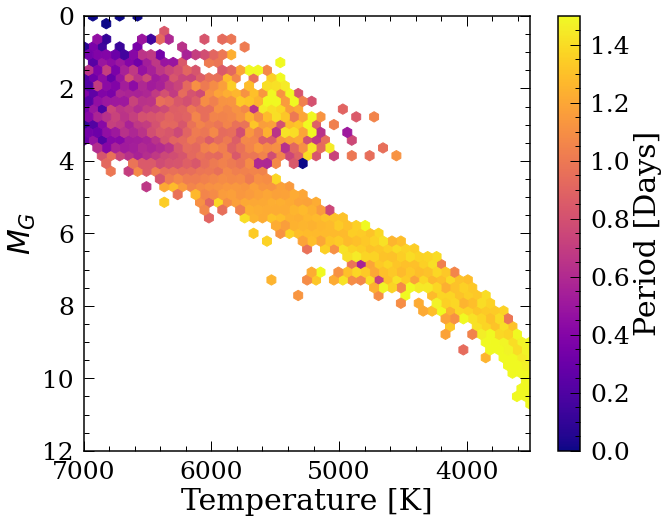

In [23]:
plt.figure(figsize=(10,8))
plt.hexbin(df_nob['teff_calc'], df_nob['abs_G'], C=np.log10(df_nob['Prot']),
          cmap='plasma', vmin=0, vmax=1.5, extent=(3500, 7000, 0, 12),
          gridsize=50)
plt.xlim([7000, 3500])
plt.ylim([12, 0])
cb = plt.colorbar()
cb.set_label('Period [Days]')
plt.xlabel('Temperature [K]')
plt.ylabel('$M_G$')